# Julia packages

In [ ]:
import Pkg
Pkg.add("Gen")
Pkg.add("Plots")
Pkg.add("StatsBase")

In [53]:
import Random, Logging
using Gen, Plots
using StatsBase: mean

In [ ]:
import ..GenExerciseUtils

# Part 2: Basics of Iterative Inference Programming

### Extra Exercise:

Part 2 of the tutorial uses a function named `visualize_trace` for the visualizations. Unfortunately, I wasn't able to access the visualization/regression_viz.jl script that contains this function. Thus, I define my own functions to reproduce the tutorial visualizations.

In [3]:
@gen function regression_with_outliers(xs::Vector{<:Real})

    slope ~ normal(0, 2)
    intercept ~ normal(0, 2)
    noise ~ gamma(1, 1)
    prob_outlier ~ uniform(0, 1)

    n = length(xs)
    ys = Float64[]

    for i = 1:n

        if ({:data => i => :is_outlier} ~ bernoulli(prob_outlier))
            (mu, std) = (0., 10.)
        else
            (mu, std) = (xs[i] * slope + intercept, noise)
        end

        push!(ys, {:data => i => :y} ~ normal(mu, std))
    end
    ys
end;

In [4]:
function extract_data_from_trace(trace)
    xs, = get_args(trace)
    ys = get_retval(trace)

    is_outliers = Bool[]
    for i in 1:length(xs)
        push!(is_outliers, getindex(trace, :data => i => :is_outlier))
    end

    return xs, ys, is_outliers
end

extract_data_from_trace (generic function with 1 method)

In [5]:
function plot_trace_with_data(trace; title::Union{Nothing, String}=nothing)
    if title !== nothing
        plot(title=title)
    else
        plot()
    end

    xs, ys, is_outliers = extract_data_from_trace(trace)

    scatter!(xs[.!is_outliers], ys[.!is_outliers], color=:blue, legend=false)
    scatter!(xs[is_outliers], ys[is_outliers], color=:red, legend=false)

    # Plot dark grey shading between two parallel lines to the regression line
    noise = trace[:noise]
    regression_line_y = trace[:intercept] .+ trace[:slope] .* xs
    upper_shade_y = regression_line_y .+ noise  # Perform element-wise addition with broadcasting
    lower_shade_y = regression_line_y .- noise  # Perform element-wise subtraction with broadcasting
    plot!(xs, upper_shade_y, fillrange=lower_shade_y, fillalpha=0.5, color=:darkgrey, legend=false)  # Adjusted fillalpha

    # Plot light grey shading between y = 10 and y = -10 vertical lines
    plot!([minimum(xs), maximum(xs)], [10, 10], fillrange=[-10, -10], fillalpha=0.2, color=:lightgrey, legend=false)

    # Plot the regression line
    plot!(xs, regression_line_y, color=:black, linestyle=:solid, legend=false)

    ylims!(-20, 20)
end



plot_trace_with_data (generic function with 1 method)

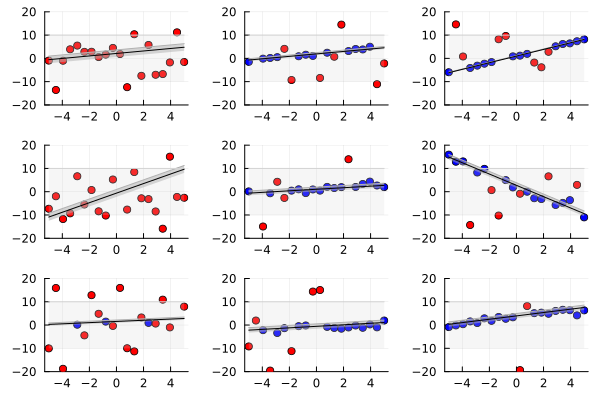

In [6]:
function grid(renderer::Function, traces)
    Plots.plot(map(renderer, traces)...)
end;

xs = collect(range(-5, stop=5, length=20))
traces = [Gen.simulate(regression_with_outliers, (xs,)) for i in 1:9]
grid(plot_trace_with_data, traces)

### Exercise 1: Analyzing the algorithms

Run the cells in the tutorial on Gaussian Drift and Block Resimulation several times. Compare the two algorithms with respect to the following:

How fast do they find a relatively good line?

Does one of them tend to get stuck more than the other? Under what conditions? Why?

The Gaussian drift proposal tends to find a relatively good line faster compared to block resimulation. This is because the Gaussian drift proposal explores the parameter space by perturbing the current parameter values, allowing it to quickly navigate towards regions of higher probability.
On the other hand, block resimulation involves resimulating all-new values for the selected addresses, which can be more computationally expensive and may take longer to converge to a good solution.

Block resimulation is more likely to get stuck when the initial proposal results in a low-probability region or when the parameter space has complex, multimodal distributions.
The Gaussian drift proposal may get stuck if the step size of the perturbation is too small, limiting its ability to explore the parameter space effectively. Additionally, it may struggle in high-dimensional parameter spaces where local optima are prevalent.

### Exercise 2: Improving the heuristic

Currently, the RANSAC heuristic does not use the current trace’s information at all. Try changing it to use the current state as follows: Instead of a constant eps parameter that controls whether a point is considered an inlier, make this decision based on the currently hypothesized noise level. Specifically, set eps to be equal to the noise parameter of the trace.

Examine whether this improves inference (no need to respond in words here).

In [43]:
@gen function ransac_proposal_noise_based(prev_trace, xs, ys)
    params = RANSACParams(10, 3, prev_trace[:noise])
    (slope_guess, intercept_guess) = ransac(xs, ys, params)
    slope ~ normal(slope_guess, 0.1)
    intercept ~ normal(intercept_guess, 1.0)
    return params, slope, intercept # (return values just for testing)
end;

In [44]:
# the following test codes are taken directly from the Gen's tutorial

function ransac_update_noise_based(tr)
    # Use RANSAC to (potentially) jump to a better line
    (tr, _) = mh(tr, ransac_proposal_noise_based, (xs, ys))
    # Refining the parameters
    for j=1:20
        (tr, _) = mh(tr, select(:prob_outlier))
        (tr, _) = mh(tr, select(:noise))
        (tr, _) = mh(tr, line_proposal, ())
        # Reclassify outliers
        for i=1:length(get_args(tr)[1])
            (tr, _) = mh(tr, select(:data => i => :is_outlier))
        end
    end
    tr
end;
function ransac_inference_noise_based(xs, ys, observations)
    # Use an initial epsilon value of 1.
    (slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
    slope_intercept_init = choicemap()
    slope_intercept_init[:slope] = slope
    slope_intercept_init[:intercept] = intercept
    (tr, _) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))
    for iter=1:5
        tr = ransac_update_noise_based(tr)
    end
    tr
end

scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = ransac_inference_noise_based(xs, ys, observations)
    scores[i] = get_score(tr)
end
println("Log probability: ", logmeanexp(scores))

  0.526648 seconds (2.49 M allocations: 153.618 MiB, 8.72% gc time, 21.54% compilation time)
  0.720529 seconds (2.35 M allocations: 146.081 MiB, 11.33% gc time)
  0.562722 seconds (2.35 M allocations: 146.081 MiB, 16.88% gc time)
  0.543092 seconds (2.35 M allocations: 146.081 MiB, 8.77% gc time)
  0.578892 seconds (2.35 M allocations: 146.081 MiB, 8.00% gc time)
  1.087935 seconds (2.35 M allocations: 146.081 MiB, 18.41% gc time)
  0.523470 seconds (2.35 M allocations: 146.081 MiB, 10.36% gc time)
  0.364689 seconds (2.35 M allocations: 146.081 MiB, 20.63% gc time)
  0.321668 seconds (2.35 M allocations: 146.081 MiB, 11.79% gc time)
  0.327620 seconds (2.35 M allocations: 146.081 MiB, 11.24% gc time)
Log probability: -45.4522128841297


### Exercise 3:

Implement a heuristic-based proposal that selects the points that are currently classified as inliers, finds the line of best fit for this subset of points, and adds some noise.

Hint: you can get the result for linear regression using least squares approximation by solving a linear system using Julia’s backslash operator, \ (as is done in the ransac function, above). See also a simple demonstration here.

We provide some starter code. You can test your solution by modifying the plotting code above.

In [45]:
@gen function inlier_heuristic_proposal(prev_trace, xs, ys)

    # estimate slope and intercept using least squares
    A = hcat(xs, ones(length(xs)))
    inlier_slope, inlier_intercept = A \ ys # use backslash operator for least sq soln

    slope     ~ normal(inlier_slope, 0.5)
    intercept ~ normal(inlier_intercept, 0.5)

    return inlier_slope, inlier_intercept
end;

function inlier_heuristic_update(tr)

    (tr, _) = mh(tr, inlier_heuristic_proposal, (xs, ys))

    for j=1:20
        (tr, _) = mh(tr, select(:prob_outlier))
        (tr, _) = mh(tr, select(:noise))
        (tr, _) = mh(tr, line_proposal, ())

        for i=1:length(get_args(tr)[1])
            (tr, _) = mh(tr, select(:data => i => :is_outlier))
        end
    end
    tr
end

inlier_heuristic_update (generic function with 1 method)

[ Info: Saved animation to /content/tmp.gif


Plots.AnimatedGif("/content/tmp.gif")
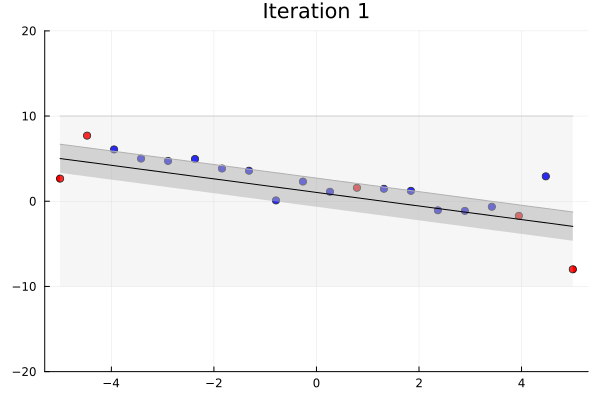

In [46]:
tr, = Gen.generate(regression_with_outliers, (xs,), observations)
viz = @animate for i in 1:50
    global tr
    tr = inlier_heuristic_update(tr)
    plot_trace_with_data(tr; title="Iteration $i")
end
gif(viz)

### Exercise 4: Initialization

In our inference program above, when generating an initial trace on which to iterate, we initialize the slope and intercept to values proposed by RANSAC. If we don’t do this, the performance decreases sharply, despite the fact that we still propose new slope/intercept pairs from RANSAC once the loop starts. Why is this?

The reason initializing the slope and intercept to values proposed by RANSAC improves performance is that it provides a good starting point for the subsequent MCMC inference process.

When we initialize the slope and intercept randomly, there's a higher chance that they are far from the optimal values. As a result, the MCMC algorithm might need more iterations to explore the parameter space and converge to a good solution.

### Exercise 5

For this dataset, the code below will run (i) Metropolis hastings with a Gaussian Drift proposal and (ii) MAP optimization, using implementations from above. Make sure you understand what it is doing. Do both algorithms explore both modes (i.e. both possible explanations)? Play with running the algorithms multiple times.

If one or both algorithms doesn’t then explain in a few sentences why you think this is.

To explain what the code is doing exactly, I will add line-by-line comments over the codes

i.   MH Gaussian drift score -68.14630592163181
ii.  MAP final score: -41.01265556241438.


[ Info: Saved animation to /content/tmp.gif


Plots.AnimatedGif("/content/tmp.gif")
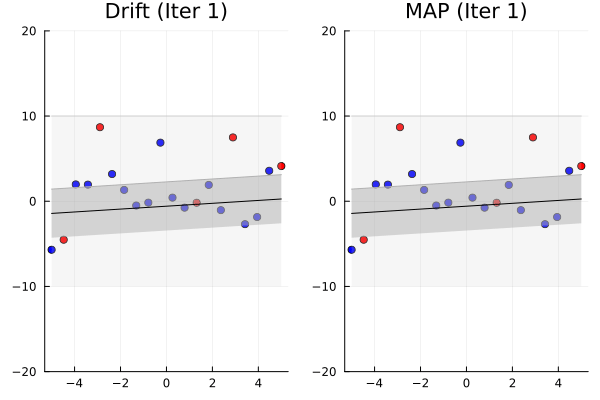

In [85]:
# Initialize two traces, one for Gaussian drift update and another for MAP update
(slope, intercept) = ransac(xs, ys_bimodal, RANSACParams(10, 3, 1.))
slope_intercept_init = choicemap()
slope_intercept_init[:slope] = slope
slope_intercept_init[:intercept] = intercept
(tr,) = generate(
    regression_with_outliers, (xs,),
    merge(observations_bimodal, slope_intercept_init))

tr_drift = tr  # We initialize trace for the Gaussian drift update
tr_map   = tr  # We initialize trace for the MAP update

viz = Plots.@animate for i in 1:305
    global tr_map, tr_drift
    if i < 6
        # For the first 5 iterations, we perform RANSAC update for both traces
        tr_drift = ransac_update(tr)
        tr_map   = tr_drift
    else
        # For subsequent iterations:
        # We perform MAP optimization on the trace with respect to slope, intercept, and noise
        tr_map = map_optimize(tr_map, select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
        tr_map = map_optimize(tr_map, select(:noise), max_step_size=1e-2, min_step_size=1e-5)

        # We choose the most likely classification of outliers (MAP update)
        tr_map = is_outlier_map_update(tr_map)

        # We update the probability of being an outlier based on the current trace
        optimal_prob_outlier = mean([tr_map[:data => i => :is_outlier] for i in 1:length(xs)])
        optimal_prob_outlier = min(0.5, max(0.05, optimal_prob_outlier))
        tr_map, = update(tr_map, (xs,), (NoChange(),), choicemap(:prob_outlier => optimal_prob_outlier))

        # We perform Gaussian drift update on the other trace
        tr_drift = gaussian_drift_update(tr_drift)
    end

    # Now, we plot the traces for both updates
    Plots.plot(plot_trace_with_data(tr_drift; title="Drift (Iter $i)"), plot_trace_with_data(tr_map; title="MAP (Iter $i)"))
end

# At the end, we compute final scores for both updates and generate a GIF animation
drift_final_score = get_score(tr_drift)
map_final_score = get_score(tr_map)
println("i.   MH Gaussian drift score $(drift_final_score)")
println("ii.  MAP final score: $(final_score).")
gif(viz)

The above was good for an overall qualitative examination, but let’s also examine a little more quantitatively how often the two proposals explore the two modes, by running multiple times and keeping track of how often the slope is positive/negative for each, for a few different initializations.

In [86]:
total_runs = 25;

In [56]:
# We iterate over the enumerated values (1, 0), (-1, 0), and the (best_slope, best_intercept) vector for xs and ys_bimodal (output from the ransac algorithm)
for (index, value) in enumerate([(1, 0), (-1, 0), ransac(xs, ys_bimodal, RANSACParams(10, 3, 1.))])
    n_pos_drift = n_neg_drift = n_pos_map = n_neg_map = 0  # Initialize counters

    # We perform multiple runs of the experiment
    for i=1:total_runs
        pos_drift = neg_drift = pos_map = neg_map = false  # First we initialize boolean variables

        #### RANSAC for initializing
        # Initialize the slope and intercept using RANSAC or from the enumerated value
        (slope, intercept) = value
        slope_intercept_init = choicemap()
        slope_intercept_init[:slope] = slope
        slope_intercept_init[:intercept] = intercept
        # Generate an initial trace with the chosen slope and intercept
        (tr,) = generate(
            regression_with_outliers, (xs,),
            merge(observations_bimodal, slope_intercept_init))

        # Run RANSAC update for 5 iterations to initialize the trace
        for iter=1:5
            tr = ransac_update(tr)
        end
        ransac_score = get_score(tr)  # Get the score of the trace after RANSAC initialization
        tr_drift = tr  # Version of the trace for the Gaussian drift algorithm
        tr_map = tr    # Version of the trace for the MAP optimization

        #### Refine the parameters according to each of the algorithms
        for iter = 1:300
            # MAP optimization:
            # Take a single gradient step on the line parameters.
            tr_map = map_optimize(tr_map, select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
            tr_map = map_optimize(tr_map, select(:noise), max_step_size=1e-2, min_step_size=1e-5)
            # Choose the most likely classification of outliers.
            tr_map = is_outlier_map_update(tr_map)
            # Update the prob outlier
            optimal_prob_outlier = count(i -> tr_map[:data => i => :is_outlier], 1:length(xs)) / length(xs)
            optimal_prob_outlier = min(0.5, max(0.05, optimal_prob_outlier))
            (tr_map, _) = update(tr_map, (xs,), (NoChange(),), choicemap(:prob_outlier => optimal_prob_outlier))

            # Gaussian drift update:
            tr_drift = gaussian_drift_update(tr_drift)

            # Check if the slope is positive or negative for both updates
            if tr_drift[:slope] > 0
                pos_drift = true
            elseif tr_drift[:slope] < 0
                neg_drift = true
            end
            if tr_map[:slope] > 0
                pos_map = true
            elseif tr_map[:slope] < 0
                neg_map = true
            end

        end

        # Update counters based on the slope direction for both updates
        if pos_drift
            n_pos_drift += 1
        end
        if neg_drift
            n_neg_drift += 1
        end
        if pos_map
            n_pos_map += 1
        end
        if neg_map
            n_neg_map += 1
        end
    end

    # Finally, we print the results for each enumerated value
    (slope, intercept) = value
    println("\n\nWITH INITIAL SLOPE $(slope) AND INTERCEPT $(intercept)")
    println("TOTAL RUNS EACH: $(total_runs)")
    println("\n       times neg. slope    times pos. slope")
    println("\ndrift: $(n_neg_drift)                  $(n_pos_drift)")
    println("\nMAP:   $(n_neg_map)                    $(n_pos_map)")
end




WITH INITIAL SLOPE 1 AND INTERCEPT 0
TOTAL RUNS EACH: 25

       times neg. slope    times pos. slope

drift: 23                  21

MAP:   9                    18


WITH INITIAL SLOPE -1 AND INTERCEPT 0
TOTAL RUNS EACH: 25

       times neg. slope    times pos. slope

drift: 25                  13

MAP:   21                    9


WITH INITIAL SLOPE -0.5430168713223773 AND INTERCEPT 0.09664445656263539
TOTAL RUNS EACH: 25

       times neg. slope    times pos. slope

drift: 25                  12

MAP:   17                    10


## Part 3 - Data-Driven Proposals